Importing packages

In [1]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
from shapely.geometry import Point, Polygon
from shapely.geometry.polygon import orient

## Loading EPM and left whiskers data set and cleaning up column names

In [2]:
#Loading EPM dataset 
path = r'examples/EPM/EPM_11DLC_snapshot-1000.h5'
df = pd.read_hdf(path)

#Changing column names of EPM dataset to be a bit more sensible
sensible_names=[]
for col in df.columns:
    name= col[1]+'_'+col[2]
    sensible_names.append(name)
df.columns= sensible_names


columns_list = df.columns.to_list()

In [3]:
#Loading left whiskers dataset
path = r'examples/new_example_with_mp4/left/M6_3_L_20231122172927DLC_resnet50_Magrat_whisk_LJan19shuffle1_1030000.h5'
df_whisker = pd.read_hdf(path)

#Changing column names of left whiskers data set to be a bit more sensible
sensible_names=[]
for col in df_whisker.columns:
    name= col[1]+'_'+col[2]
    sensible_names.append(name)
df_whisker.columns= sensible_names


columns_list = df_whisker.columns.to_list()

### 4.1.1 Relative headangles
Calculating relative headangle between mouse center and head midpoint, and plotting the variation of these over time

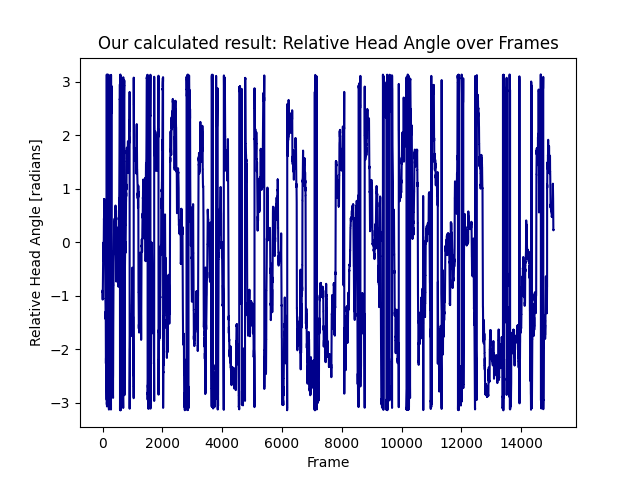

In [4]:
#Filtering dataframe to only contain positional data
body_df = df[[col for col in df.columns if "x" in col or "y" in col]]
body_df = body_df.copy().drop(columns = ["right_eye_likelihood", "left_eye_likelihood"])

#Filtering dataframe to only contain positional data for mouse center and head midpoint
angle_df = body_df.copy()[["mouse_center_x", "mouse_center_y", "head_midpoint_x","head_midpoint_y"]]  


#When calculating the relative headangles we assume that the middle point is in origo
delta_x = angle_df["head_midpoint_x"]-angle_df["mouse_center_x"]
delta_y = angle_df["head_midpoint_y"]-angle_df["mouse_center_y"]

df_comp2 = pd.concat([delta_x, delta_y], axis = 1)
df_comp2.columns = ["delta_x", "delta_y"]
df_comp2["rel_angles"] = np.arctan2(delta_y, delta_x)

#Plotting relative headangles in radians over all frames of the video

relangles = df_comp2["rel_angles"].to_numpy()

frames = np.arange(len(relangles))

plt.plot(frames, relangles, color = "darkblue")

plt.xlabel("Frame")

plt.ylabel("Relative Head Angle [radians]")

plt.title("Our calculated result: Relative Head Angle over Frames")
plt.show()

### 4.1.2 Calculating total distance traveled by the animal.

Through the animal center of mass, without taking into consideration the body keypoints

In [5]:
#Creating two new dataframes which separates the x-coordinate and y-coordinate for each keypoint
x_body_df = body_df[[col for col in body_df.columns if "x" in col]]
y_body_df = body_df[[col for col in body_df.columns if "y" in col]]

#Filtering out tail keypoints
x_body_df = x_body_df.copy()[['nose_x', 'left_ear_x', 'right_ear_x', 'left_ear_tip_x',
       'right_ear_tip_x', 'left_eye_x', 'right_eye_x', 'neck_x', 'mid_back_x',
       'mouse_center_x', 'mid_backend_x', 'mid_backend2_x', 'mid_backend3_x',
       #'tail_base_x', 'tail1_x', 'tail2_x', 'tail3_x', 'tail4_x', 'tail5_x',
       'left_shoulder_x', 'left_midside_x', 'left_hip_x', 'right_shoulder_x',
       'right_midside_x', 'right_hip_x', #'tail_end_x',
        'head_midpoint_x']]
y_body_df = y_body_df.copy()[['nose_y', 'left_ear_y', 'right_ear_y', 'left_ear_tip_y',
       'right_ear_tip_y', #'left_eye_x',
        'left_eye_y',
        #'left_eye_likelihood',
       #'right_eye_x',
       'right_eye_y',
        #'right_eye_likelihood',
        'neck_y',
       'mid_back_y', 'mouse_center_y', 'mid_backend_y', 'mid_backend2_y',
       'mid_backend3_y', #'tail_base_y', 'tail1_y', 'tail2_y', 'tail3_y',
       #'tail4_y', 'tail5_y',
       'left_shoulder_y', 'left_midside_y', 'left_hip_y',
       'right_shoulder_y', 'right_midside_y', 'right_hip_y', #'tail_end_y',
       'head_midpoint_y']]

# Calculating CM
x_body_df["cm_x"] = x_body_df.mean(axis = 1)
y_body_df["cm_y"] = y_body_df.mean(axis = 1)

# CM dataframe
cm_df = pd.DataFrame({
    "cm_x": x_body_df["cm_x"],
    "cm_y": y_body_df["cm_y"]
})

# Calculating the total distance 
cm_diff = cm_df.diff().iloc[1:]
dist_diff = np.sqrt(np.sum(cm_diff**2, axis = 1))
total_dist = np.sum(dist_diff)

print(total_dist)

37818.695781646355


The animal has travelled 37818.696 pixels in total

### 4.1.3 Calculating the angle between vector BB and BT for all keypoints

In [6]:
#Filtering dataframe so that it only contains positional data
body_df_whisker = df_whisker[[col for col in df_whisker.columns if "x" in col or "y" in col]]

#Getting all keypoint names
x_list = []

for col in body_df_whisker.columns:
    if col[-2:]=="_x":
        x_list.append(col[:-2])


#Generating four lists that contain tuples that correspond to x- and y-coordinates keypointnames, for each keypoint in each strand.
xy_pairs_2_base = []

xy_pairs_2_trunk = []

xy_pairs_3_base = []

xy_pairs_3_trunk = []

for ele in x_list:
    if ele[0] =="2":
        if "base" in ele:
            xy_pairs_2_base.append((ele+"_x", ele+"_y"))
        else:
            xy_pairs_2_trunk.append((ele+"_x", ele+"_y"))
    else:
        if "base" in ele:
            xy_pairs_3_base.append((ele+"_x", ele+"_y"))
        else:
            xy_pairs_3_trunk.append((ele+"_x", ele+"_y"))



#Calculating the angles and storing them in lists splitting them based on which strand they belong to.
#Each element in each list contain a nparray corresponding to how each angle vary for all frames of the video 
angles_2 = []
angles_3 = []
for j in range(len(xy_pairs_2_base)-1):
    BT_2_mag = np.sqrt((body_df_whisker[xy_pairs_2_base[j][0]]-body_df_whisker[xy_pairs_2_trunk[j][0]])**2+(body_df_whisker[xy_pairs_2_base[j][1]]-body_df_whisker[xy_pairs_2_trunk[j][1]])**2)
    BT_3_mag = np.sqrt((body_df_whisker[xy_pairs_3_base[j][0]]-body_df_whisker[xy_pairs_3_trunk[j][0]])**2+(body_df_whisker[xy_pairs_3_base[j][1]]-body_df_whisker[xy_pairs_3_trunk[j][1]])**2)

    BB_2_mag = np.sqrt((body_df_whisker[xy_pairs_2_base[j][0]]-body_df_whisker[xy_pairs_2_base[j+1][0]])**2+(body_df_whisker[xy_pairs_2_base[j][1]]-body_df_whisker[xy_pairs_2_base[j+1][1]])**2)
    BB_3_mag = np.sqrt((body_df_whisker[xy_pairs_3_base[j][0]]-body_df_whisker[xy_pairs_3_base[j+1][0]])**2+(body_df_whisker[xy_pairs_3_base[j][1]]-body_df_whisker[xy_pairs_3_base[j+1][1]])**2)

    DOT_2 = (body_df_whisker[xy_pairs_2_base[j][0]]-body_df_whisker[xy_pairs_2_trunk[j][0]])*(body_df_whisker[xy_pairs_2_base[j][0]]-body_df_whisker[xy_pairs_2_base[j+1][0]])+(body_df_whisker[xy_pairs_2_base[j][1]]-body_df_whisker[xy_pairs_2_trunk[j][1]])*(body_df_whisker[xy_pairs_2_base[j][1]]-body_df_whisker[xy_pairs_2_base[j+1][1]])
    DOT_3 = (body_df_whisker[xy_pairs_3_base[j][0]]-body_df_whisker[xy_pairs_3_trunk[j][0]])*(body_df_whisker[xy_pairs_3_base[j][0]]-body_df_whisker[xy_pairs_3_base[j+1][0]])+(body_df_whisker[xy_pairs_3_base[j][1]]-body_df_whisker[xy_pairs_3_trunk[j][1]])*(body_df_whisker[xy_pairs_3_base[j][1]]-body_df_whisker[xy_pairs_3_base[j+1][1]])

    cos_theta_2 = pd.Series.to_numpy(DOT_2/(BT_2_mag*BB_2_mag))
    cos_theta_3 = pd.Series.to_numpy(DOT_3/(BT_3_mag*BB_3_mag))
  
    angles_2.append(np.degrees(np.arccos(np.clip(cos_theta_2, -1.0, 1.0))))
    angles_3.append(np.degrees(np.arccos(np.clip(cos_theta_3, -1.0, 1.0))))


print(angles_2)
print(angles_3)

[array([147.52819551, 151.92640215, 149.75311881, ..., 138.77328942,
       135.4401378 , 141.98592634]), array([155.66782603, 156.5322485 , 153.48610896, ..., 127.1007848 ,
       126.49547427, 128.3171668 ]), array([154.60245824, 158.91794159, 160.04235285, ...,  85.81346498,
        84.20747093,  87.48940603]), array([134.91119793, 133.9445471 , 136.05270277, ...,  42.96621048,
        42.68619332,  43.53498843])]
[array([117.38256747, 120.21264328, 121.92731768, ...,  94.01267123,
        93.33491963,  94.70888441]), array([111.71238964, 111.14044725, 110.4832759 , ...,  81.82325499,
        78.81332226,  84.17533767]), array([132.31813788, 128.28754017, 130.10723193, ...,  74.37264854,
        76.01022557,  77.21576032]), array([105.57905121, 105.59598895, 105.11573184, ...,  52.95887087,
        52.81147683,  51.76928638])]


## 4.2.1

In [7]:
#Filtering dataframe so that it only contains positional data
body_df = df[[col for col in df.columns if "x" in col or "y" in col]]
body_df = body_df.copy().drop(columns = ["right_eye_likelihood", "left_eye_likelihood"])

#Making a new dataframe where each column consists of keypoint names, and where each element consists of a tuple holding the x and y-coordinates for the corresponding keypoint.
x_list = []

for col in body_df.columns:
    if col[-2:]=="_x":
        x_list.append(col[:-2])

coor_tuples = []

for ele in x_list:
    coor_tuples.append((ele+"_x", ele+"_y"))

matrix_tupled = []

for ele in coor_tuples:
    matrix_tupled.append(list(zip(body_df[ele[0]], body_df[ele[1]])))

df_tupled = pd.DataFrame(matrix_tupled).T

df_tupled.columns = [x_list]

In [8]:
# Get the frame rate
video_path = "examples/EPM/EPM_11.mp4"
cap = cv2.VideoCapture(video_path)

# Get the frame rate and total frames
fps = cap.get(cv2.CAP_PROP_FPS)

total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

cap.release()

 ### Q1 Plotting bar graphs where the first bar represents the total time the animal spends inside ROI0 and second bar represents the total time the animal spends outside ROI0.

Total duration in seconds inside: 424.6
Total duration in seconds outside: 178.44


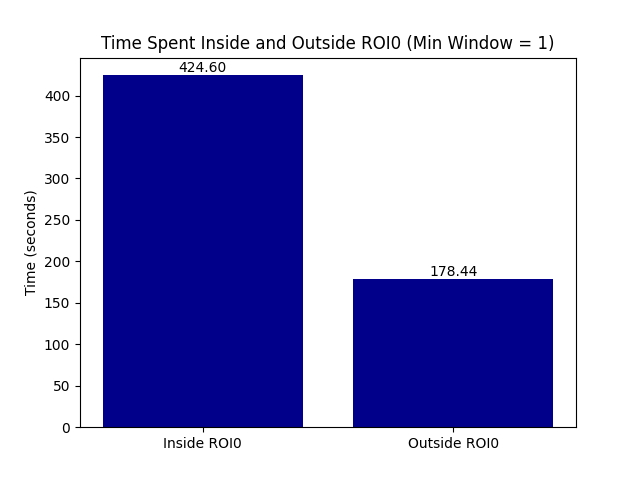

In [9]:
#Function that takes in one point and checks if it is inside ROI0 
def point_inside(point):
    quad_vertices = [(210, 507), (210, 424), (989, 435), (987, 523), (210, 507)]
    quadrilateral = Polygon(quad_vertices)
    point = Point(point)
    ordered_quad = orient(quadrilateral, sign=1.0)  
    is_inside = ordered_quad.contains(point)
    return is_inside

#Creating a new data frame, where each element is a boolean. True if inside ROI0 and False if outside ROI0.
df_booled = df_tupled.copy().map(point_inside)

#We consider an animal to be inside ROI0 at a particular frame if any keypoint is inside ROI0 at that frame

df_booled["inside"] = df_booled.apply(any, axis = 1)

#When inside, check the duration of True. I.e how long till it changes to False.

#Creating a changes list, where the first element contains the frame index where the animal changes from inside to outside ROI0.
#The second element contains the boolean value it changes from and the third element contains the boolean value it changes to
booled_list = df_booled["inside"].values.tolist()
changes = [[i, booled_list[i-1], booled_list[i]] for i in range(1, len(booled_list)) if booled_list[i] != booled_list[i-1]]

#Calculating total duration the animal is inside ROI0
total_duration = 0

#If the animal starts with being inside ROI0, then we add the amount of frames it is inside it. 
if changes[0][1][0]==True:
    total_duration += changes[0][0]


for j in range(len(changes)):
    #If we are at the last change and it changes from being false to true, then add frame duration
    if j==(len(changes)-1) and changes[j][1][0]==False:
        total_duration += total_frames-changes[j][0]
    #If it changes from being false to true, then add frame duration
    elif changes[j][1][0]==False and (changes[j+1][0]-changes[j][0])>0:
        total_duration += (changes[j+1][0]-changes[j][0])

#Calculating total duration the animal is inside ROI0 in seconds
total_duration_s_inside = total_duration/(fps)


print("Total duration in seconds inside:", total_duration_s_inside)

#Similar logic as above to find total duration outside
total_duration = 0
if changes[0][1][0]==False:
    total_duration += changes[0][0]


for j in range(len(changes)):
    if j==(len(changes)-1) and changes[j][1][0]==True:
        total_duration += total_frames-changes[j][0]
    elif changes[j][1][0]==True and (changes[j+1][0]-changes[j][0])>0:
        total_duration += (changes[j+1][0]-changes[j][0])


total_duration_s_outside = total_duration/(fps)


print("Total duration in seconds outside:", total_duration_s_outside)

# Plotting the bar graph
fig, ax = plt.subplots()
bars = ax.bar(['Inside ROI0', 'Outside ROI0'], [total_duration_s_inside, total_duration_s_outside], color=['darkblue', 'darkblue'])
ax.set_ylabel('Time (seconds)')
ax.set_title('Time Spent Inside and Outside ROI0 (Min Window = 1)')

# Add the total duration on top of the bars
for bar, duration in zip(bars, [total_duration_s_inside, total_duration_s_outside]):
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        f'{duration:.2f}',
        ha='center',
        va='bottom'
    )

## 4.2.2

###  When is the animal close to the open arm, if I define close as less than 50

In [10]:
#Function that takes in one point and checks if it is close to ROI0
def point_close(point):
    quad_vertices = [(200, 513), (206, 422), (995, 441),(995, 529), (200, 513)]
    quadrilateral = Polygon(quad_vertices)
    ordered_quad = orient(quadrilateral, sign=1.0)
    point = Point(point)  
    is_inside = (ordered_quad.distance(point)< 50)
    return is_inside

#Creating a new data frame, where each element is a boolean. True if close to ROI0 and False if not close to ROI0.
df_booled = df_tupled.copy().map(point_close)


#We consider an animal to be close to ROI0 at a particular frame if any keypoint is close to ROI0 at that frame

df_booled["inside"] = df_booled.apply(any, axis = 1)


#Creating a changes list, where the first element contains the frame index where the animal changes boolean values.
#The second element contains the boolean value it changes from and the third element contains the boolean value it changes to
booled_list = df_booled["inside"].values.tolist()
changes = [[i, booled_list[i-1], booled_list[i]] for i in range(1, len(booled_list)) if booled_list[i] != booled_list[i-1]]

entries = []
endings = []

# Here the min window is 10
if changes[0][1][0]==True and changes[0][0]>9:
    entries.append(0)
    endings.append(changes[1][0]-1)


# Similar logic 
for j in range(len(changes)):
    if j==(len(changes)-1) and changes[j][1][0]==False:
        if (total_frames-changes[j][0])>9:
            entries.append(changes[j][0])
            endings.append(total_frames)
    elif changes[j][1][0]==False and (changes[j+1][0]-changes[j][0])>9:
        entries.append(changes[j][0])
        endings.append(changes[j+1][0]-1)

# Finding duration in frames and duration in seconds
entries = np.array(entries)
endings = np.array(endings)

dur_frames = endings-entries
dur_sec = dur_frames/fps


print("Entry times:", entries)
print("Ending times:", endings)
print("Dur frames:", dur_frames)
print("Dur secs:", dur_sec)

Entry times: [    0   892  1037  1187  1729  1871  1902  2192  2214  2254  2286  3193
  3221  3376  3454  4200  4779  4835  4867  5079  5117  6160  6495  6572
  6789  7671  7689  8066  8081  8193  8724  8768  8785  9904 10031 10539
 10587 10623 11143 11340 11401 12707 13857 14456 14473 14501 14537 14849
 14910]
Ending times: [  852   963  1104  1695  1817  1881  2167  2205  2233  2269  3089  3219
  3316  3394  4137  4228  4795  4863  5003  5114  6106  6402  6513  6702
  6830  7686  7968  8079  8093  8678  8747  8781  9823 10008 10444 10583
 10604 11103 11314 11375 12623 12755 14413 14469 14499 14521 14780 14892
 15076]
Dur frames: [ 852   71   67  508   88   10  265   13   19   15  803   26   95   18
  683   28   16   28  136   35  989  242   18  130   41   15  279   13
   12  485   23   13 1038  104  413   44   17  480  171   35 1222   48
  556   13   26   20  243   43  166]
Dur secs: [34.08  2.84  2.68 20.32  3.52  0.4  10.6   0.52  0.76  0.6  32.12  1.04
  3.8   0.72 27.32  1.12  0.

### When is the animal close to the open arm, if I define close as less than 50, and outside it

In [11]:
#Checks if a point is outside ROI0
def point_outside(point):
    quad_vertices =[(200, 513), (206, 422), (995, 441),(995, 529), (200, 513)]
    quadrilateral = Polygon(quad_vertices)
    point = Point(point)  
    ordered_quad = orient(quadrilateral, sign=1.0)
    is_inside = (ordered_quad.contains(point))
    return (not is_inside)

#Checks if a point is close to ROI0
def point_close(point):
    quad_vertices =[(200, 513), (206, 422), (995, 441),(995, 529), (200, 513)]
    quadrilateral = Polygon(quad_vertices)
    point = Point(point)  
    ordered_quad = orient(quadrilateral, sign=1.0)
    is_dist = (ordered_quad.distance(point)<50)
    return (is_dist)

#Creating new data frames where each element is a boolean
df_booled_out = df_tupled.copy().map(point_outside)

df_booled_close = df_tupled.copy().map(point_close)



df_booled = df_tupled.copy()

#Consider a point to be outside if all keypoints are outside, and a point to be close if all points are close

df_booled["outside"] = df_booled_out.apply(all, axis = 1)

df_booled["closer"] = df_booled_close.apply(any, axis = 1)

booled_outside = df_booled["outside"].values.tolist()

booled_closer = df_booled["closer"].values.tolist()

booled_outside = np.array(booled_outside)

booled_closer = np.array(booled_closer)



#If and only if both are true 
booled_list = np.logical_and(booled_outside, booled_closer)


#Similar logic as before

changes = [[i, booled_list[i-1], booled_list[i]] for i in range(1, len(booled_list)) if booled_list[i] != booled_list[i-1]]
#Index, previous value, new value

print("Change details:", changes)

entries = []

endings = []

# Here the min window is 11
if changes[0][1][0]==True and changes[0][0]>10:
    entries.append(0)
    endings.append(changes[1][0]-1)


for j in range(len(changes)):
    if j==(len(changes)-1) and changes[j][1][0]==False:
        if (total_frames-changes[j][0])>10:
            entries.append(changes[j][0])
            endings.append(total_frames)
    elif changes[j][1][0]==False and (changes[j+1][0]-changes[j][0])>10:
        entries.append(changes[j][0])
        endings.append(changes[j+1][0]-1)

entries = np.array(entries)
endings = np.array(endings)

dur_frames = endings-entries
dur_sec = dur_frames/fps


print("Entry times:", entries)
print("Ending times:", endings)
print("Dur frames:", dur_frames)
print("Dur secs:", dur_sec)

Change details: [[825, array([False]), array([ True])], [832, array([ True]), array([False])], [920, array([False]), array([ True])], [925, array([ True]), array([False])], [958, array([False]), array([ True])], [964, array([ True]), array([False])], [1061, array([False]), array([ True])], [1065, array([ True]), array([False])], [1095, array([False]), array([ True])], [1097, array([ True]), array([False])], [1100, array([False]), array([ True])], [1105, array([ True]), array([False])], [1688, array([False]), array([ True])], [1696, array([ True]), array([False])], [1749, array([False]), array([ True])], [1752, array([ True]), array([False])], [1809, array([False]), array([ True])], [1815, array([ True]), array([False])], [2160, array([False]), array([ True])], [2167, array([ True]), array([False])], [3085, array([False]), array([ True])], [3090, array([ True]), array([False])], [3224, array([False]), array([ True])], [3227, array([ True]), array([False])], [3309, array([False]), array(

4.2.2 When is the animal close to the open arm, if I define close as less than 50, and inside the open arm

In [12]:
#Checks if a point is inside AND is close to ROI0
def point_inside_closer(point):
    quad_vertices =[(200, 513), (206, 422), (995, 441),(995, 529), (200, 513)] 
    quadrilateral = Polygon(quad_vertices)
    point = Point(point)  
    ordered_quad = orient(quadrilateral, sign=1.0)
    is_inside = (ordered_quad.contains(point))
    is_dist = (ordered_quad.distance(point)<50)
    return (is_inside and is_dist)

# Similar logic as before here
df_booled = df_tupled.copy().map(point_inside_closer)

df_booled["inside"] = df_booled.apply(any, axis = 1)

booled_list = df_booled["inside"].values.tolist()
changes = [[i, booled_list[i-1], booled_list[i]] for i in range(1, len(booled_list)) if booled_list[i] != booled_list[i-1]]

print("Change details:", changes)

entries = []
endings = []

# Here the min window is 11
if changes[0][1][0]==True and changes[0][0]>10:
    entries.append(0)
    endings.append(changes[1][0]-1)

for j in range(len(changes)):
    if j==(len(changes)-1) and changes[j][1][0]==False:
        if (total_frames-changes[j][0])>10:
            entries.append(changes[j][0])
            endings.append(total_frames)
    elif changes[j][1][0]==False and (changes[j+1][0]-changes[j][0])>10:
        entries.append(changes[j][0])
        endings.append(changes[j+1][0]-1)

entries = np.array(entries)
endings = np.array(endings)

dur_frames = endings-entries
dur_sec = dur_frames/fps


print("Entry times:", entries)
print("Ending times:", endings)
print("Dur frames:", dur_frames)
print("Dur secs:", dur_sec)

Change details: [[825, [True], [False]], [853, [False], [True]], [854, [True], [False]], [884, [False], [True]], [886, [True], [False]], [889, [False], [True]], [890, [True], [False]], [892, [False], [True]], [920, [True], [False]], [925, [False], [True]], [958, [True], [False]], [986, [False], [True]], [987, [True], [False]], [1008, [False], [True]], [1011, [True], [False]], [1012, [False], [True]], [1014, [True], [False]], [1028, [False], [True]], [1029, [True], [False]], [1031, [False], [True]], [1033, [True], [False]], [1037, [False], [True]], [1061, [True], [False]], [1065, [False], [True]], [1095, [True], [False]], [1097, [False], [True]], [1100, [True], [False]], [1108, [False], [True]], [1109, [True], [False]], [1141, [False], [True]], [1147, [True], [False]], [1148, [False], [True]], [1155, [True], [False]], [1167, [False], [True]], [1169, [True], [False]], [1170, [False], [True]], [1176, [True], [False]], [1187, [False], [True]], [1688, [True], [False]], [1697, [False], [True

## 4.2.3

### Find all displacements for each keypoint for each strand

In [13]:
body_df = df_whisker[[col for col in df_whisker.columns if "x" in col or "y" in col]]
x_list = []
y_list = []

for col in body_df.columns:
    if col[-2:]=="_x":
        x_list.append(col[:-2])
    else:
        y_list.append(col[:-2])

xy_pairs_2_base = []

xy_pairs_2_trunk = []

xy_pairs_3_base = []

xy_pairs_3_trunk = []

for ele in x_list:
    if ele[0] =="2":
        if "base" in ele:
            xy_pairs_2_base.append((ele+"_x", ele+"_y"))
        else:
            xy_pairs_2_trunk.append((ele+"_x", ele+"_y"))
    else:
        if "base" in ele:
            xy_pairs_3_base.append((ele+"_x", ele+"_y"))
        else:
            xy_pairs_3_trunk.append((ele+"_x", ele+"_y"))

displacements = body_df.diff().iloc[1:]

B_2_displacements = np.zeros((displacements.shape[0], len(xy_pairs_2_base)))

B_3_displacements = np.zeros((displacements.shape[0], len(xy_pairs_3_base)))

T_2_displacements = np.zeros((displacements.shape[0], len(xy_pairs_2_trunk)))

T_3_displacements = np.zeros((displacements.shape[0], len(xy_pairs_3_trunk)))

for j in range(len(xy_pairs_2_base)):
    B_2_displacements[:,j] = (np.sqrt(displacements[xy_pairs_2_base[j][0]]**2+displacements[xy_pairs_2_base[j][1]]**2)).to_numpy()
    B_3_displacements[:,j] = (np.sqrt(displacements[xy_pairs_3_base[j][0]]**2+displacements[xy_pairs_3_base[j][1]]**2)).to_numpy()
    T_2_displacements[:,j] = (np.sqrt(displacements[xy_pairs_2_trunk[j][0]]**2+displacements[xy_pairs_2_trunk[j][1]]**2)).to_numpy()
    T_3_displacements[:,j] = (np.sqrt(displacements[xy_pairs_3_trunk[j][0]]**2+displacements[xy_pairs_3_trunk[j][1]]**2)).to_numpy()

print("Displacements for all base keypoints on strand 2, where each row is a frame:",B_2_displacements)
print("Displacements for all base keypoints on strand 3, where each row is a frame:",B_3_displacements)
print("Displacements for all trunk keypoints on strand 2, where each row is a frame:",T_2_displacements)
print("Displacements for all trunk keypoints on strand 3, where each row is a frame:",T_3_displacements)


Displacements for all base keypoints on strand 2, where each row is a frame: [[0.9459708  0.94136698 0.92456618 0.74375615 1.34061121]
 [1.23552945 0.92801125 0.50310733 0.06802842 0.45781003]
 [0.68122368 0.28179419 1.03015317 0.40823837 0.76398881]
 ...
 [0.17740979 1.12017133 0.78623606 0.80025392 0.62933114]
 [1.08705977 0.57163311 0.12522974 0.46351821 0.50776165]
 [2.06419103 2.12443269 1.18728018 0.38078728 0.68808236]]
Displacements for all base keypoints on strand 3, where each row is a frame: [[0.89167194 0.32960399 0.5074102  1.27029444 0.81548343]
 [0.68599764 0.94954496 0.48179225 0.45076362 1.21084142]
 [0.81798105 0.52144747 0.86349512 0.64938598 0.47819891]
 ...
 [0.95463009 1.27268732 1.13957961 0.76175553 0.68429347]
 [0.1040181  0.47177    0.66977048 1.04521594 0.46238325]
 [1.32677123 1.88342035 0.41045562 0.23363688 1.09640697]]
Displacements for all trunk keypoints on strand 2, where each row is a frame: [[1.00276137 0.39371495 0.87633085 0.58067046 0.71151998]
 [

## 4.2.3 Find average displacements for each keypoint in each strand

In [14]:
B_2_means = np.zeros(len(xy_pairs_2_base))
B_3_means = np.zeros(len(xy_pairs_3_base))
T_2_means = np.zeros(len(xy_pairs_2_trunk))
T_3_means = np.zeros(len(xy_pairs_3_trunk))

for j in range(len(B_2_means)):
    B_2_means[j] = np.mean(B_2_displacements[:,j])
    B_3_means[j] = np.mean(B_3_displacements[:,j])
    T_2_means[j] = np.mean(T_2_displacements[:,j])
    T_3_means[j] = np.mean(T_3_displacements[:,j])


print("Average displacements for all base keypoints on strand 2:", B_2_means)
print("Average displacements for all base keypoints on strand 3:",B_3_means)
print("Average displacements for all trunk keypoints on strand 2:",T_2_means)
print("Average displacements for all trunk keypoints on strand 3:",T_3_means)

Average displacements for all base keypoints on strand 2: [10.24751974  1.47974077  1.40500734  1.25943403  1.37595981]
Average displacements for all base keypoints on strand 3: [1.57563588 1.44888367 1.72194343 1.72906314 1.91562788]
Average displacements for all trunk keypoints on strand 2: [9.34089398 2.30843836 2.7157083  2.9261539  2.51465652]
Average displacements for all trunk keypoints on strand 3: [2.72080798 2.54527197 2.87984386 2.92239486 2.94534548]


## 4.2.3 Plot a bar graph with the first bar representing the total time the animal the displacement is larger or equal to 2, and the second bar representing the total time the displacement is smaller than 2.

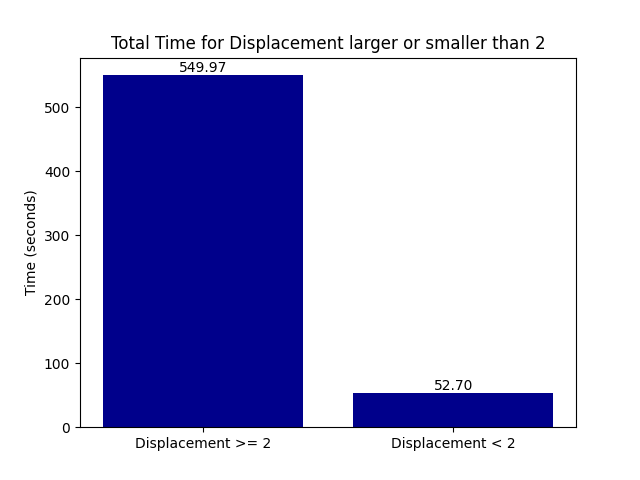

549.9666666666667
52.7047619047619


In [15]:
biggus_matrix = np.concatenate((B_2_displacements, B_3_displacements, T_2_displacements, T_3_displacements), axis = 1)

larger_2_mask = np.any(biggus_matrix >= 2, axis = 1)
smaller_2_mask = np.all(biggus_matrix < 2, axis = 1)

video_path = "examples/new_example_with_mp4/left/M6_3_L_20231122172927DLC_resnet50_Magrat_whisk_LJan19shuffle1_1030000.mp4"
cap = cv2.VideoCapture(video_path)

# Get the frame rate
fps = cap.get(cv2.CAP_PROP_FPS)

cap.release()

time_large = np.sum(larger_2_mask)/fps
time_small = np.sum(smaller_2_mask)/fps

fig, ax = plt.subplots()
bars = ax.bar(['Displacement >= 2', 'Displacement < 2'], [time_large, time_small], color = ['darkblue', 'darkblue'])
ax.set_ylabel('Time (seconds)')
ax.set_title('Total Time for Displacement larger or smaller than 2')

# Add timelarge and timesmall on top of the bargraphs
for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width()/2,
        height,                           
        f'{height:.2f}',                 
        ha='center',                      
        va='bottom'                       
    )

plt.show()

print(time_large)
print(time_small)

### 4.2.3 For each keypoint find the total time the animal the displacement is larger or equal to 2, and the total time the displacement is smaller than 2.

In [16]:
greater_mask_per_keypoint = np.sum(biggus_matrix >= 2, axis = 0)/fps
smaller_mask_per_keypoint = np.sum(biggus_matrix < 2, axis = 0)/fps

print(greater_mask_per_keypoint)
print(smaller_mask_per_keypoint)

[152.37142857  96.08095238  92.6047619   80.81428571  97.24285714
 112.64285714 112.31904762 130.89047619 149.16190476 185.24285714
 260.58095238 252.25714286 264.27142857 253.4952381  222.25238095
 245.02380952 266.13333333 294.33333333 275.87619048 274.32380952]
[450.3        506.59047619 510.06666667 521.85714286 505.42857143
 490.02857143 490.35238095 471.78095238 453.50952381 417.42857143
 342.09047619 350.41428571 338.4        349.17619048 380.41904762
 357.64761905 336.53809524 308.33809524 326.7952381  328.34761905]
